Created on 9/03/23

By Matthew Chuang

Title: Exploratory Data Analysis of Housing Prices (KNN, Multi-linear Regression) 

Import important modules:

In [58]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler

Take a look at the data:

   longitude  latitude  housing_median_age  total_rooms  total_bedrooms  \
0    -122.23     37.88                41.0        880.0           129.0   
1    -122.22     37.86                21.0       7099.0          1106.0   
2    -122.24     37.85                52.0       1467.0           190.0   
3    -122.25     37.85                52.0       1274.0           235.0   
4    -122.25     37.85                52.0       1627.0           280.0   

   population  households  median_income  median_house_value ocean_proximity  
0       322.0       126.0         8.3252            452600.0        NEAR BAY  
1      2401.0      1138.0         8.3014            358500.0        NEAR BAY  
2       496.0       177.0         7.2574            352100.0        NEAR BAY  
3       558.0       219.0         5.6431            341300.0        NEAR BAY  
4       565.0       259.0         3.8462            342200.0        NEAR BAY   



<Axes: >

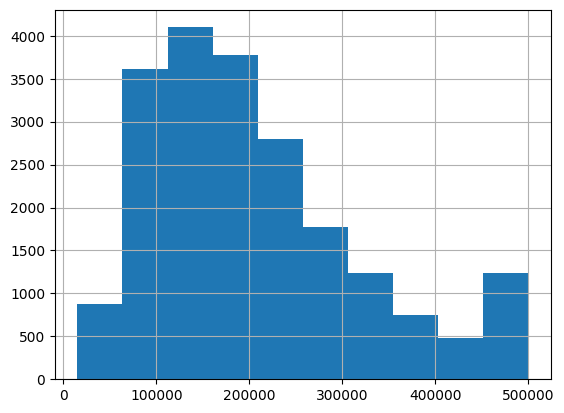

In [59]:
df = pd.read_csv('housing.csv')

print(df.head(), '\n')
df.shape

#statistics of each column: (this is to see what I can use as a predictor variable)
df.describe()

df['median_house_value'].hist()

I performed KNN regression on this dataset of housing prices as a baseline model.
This will give me an idea of the relationship between variables and be able to predict housing price based on several different types of regression. 


By skimming the Data, I observed that the column total_bedrooms had a lot of missing values.
To solve this issue, I replaced the empty values with the mean, as to not skew the data.


Cleaning the Data:


In [60]:
df['total_bedrooms'].fillna(df['total_bedrooms'].mean(), inplace=True)


To find the best predictor variable, I used correlation analysis. As for longitude and latitude I will be using a geographical visualization. 

Feature Selection:

In [61]:
#one hot encoding for categorical variables:
df = pd.get_dummies(df, columns=['ocean_proximity'], drop_first = True)
corr_func = df.corr()
#set our response variable to ascending order
predictor_correlation = corr_func['median_house_value'].sort_values(ascending = False)
print(predictor_correlation)

median_house_value            1.000000
median_income                 0.688075
ocean_proximity_NEAR BAY      0.160284
ocean_proximity_NEAR OCEAN    0.141862
total_rooms                   0.134153
housing_median_age            0.105623
households                    0.065843
total_bedrooms                0.049454
ocean_proximity_ISLAND        0.023416
population                   -0.024650
longitude                    -0.045967
latitude                     -0.144160
ocean_proximity_INLAND       -0.484859
Name: median_house_value, dtype: float64


From these correlation coefficients, I can see that median_income is the closest .

Because of the size of this data set, I will be using a train_test_split with a test size of 40% and a train size of 60%.
To ensure reproducibility, we will be using a random_state.

In [62]:
#predictor (x) variable:
x = df[['median_income']]

#response (y) variable:
y = df['median_house_value']

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, train_size = 0.6, random_state = 21)



I will be performing KNN Regression. The first step is to choose a good value for K, which will represent the number of "neighbors" to consider when making a prediction. I will be using the MSE to see which K value is the best. The MSE serves as a way to measure the difference between predicted and actual values. 

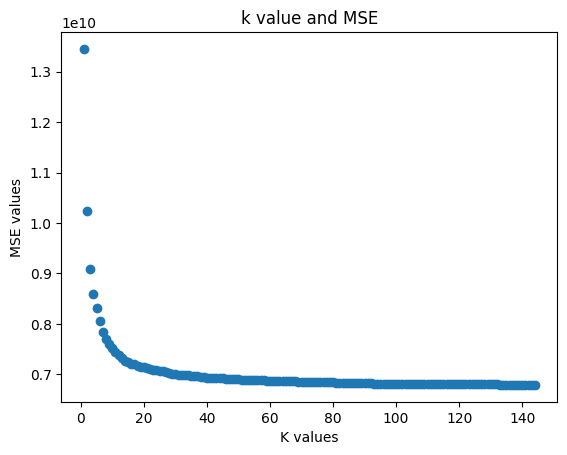

144


In [63]:
#testing a range of k values
k_min = 1
k_max = 144
k_list = np.linspace(k_min, k_max, num = 144, dtype = int)

k_dict = {}
#loop through k values
for k_value in k_list:
    model = KNeighborsRegressor(n_neighbors=int(k_value))
    #train model for k value:
    model.fit(x_train, y_train)
    y_predicted = model.predict(x_test)

    #find each MSE value and store it into a dictionary
    MSE = mean_squared_error(y_test, y_predicted)
    k_dict[k_value] = MSE

#Making sure there is a relationship between our K-values and MSE that corresponds to it
plt.scatter(list(k_dict.keys()),list(k_dict.values()))
plt.xlabel('K values')
plt.ylabel('MSE values')
plt.title('k value and MSE')
plt.show()

#The lower the MSE value, the better the k value in this case.
#Given MSE's formula that incorporates the difference between the true and predicted value for the observation, 
#a lower MSE means that the predictions are closer to the actual values. 
top_k_value = min(k_dict, key=k_dict.get)
#each value in the k_dict corresponds to a given MSE value (Kind of like hash_tables in c++)
print(top_k_value)

From this graph and for loop, it is clear that the highest K-value will hopefully give us the most accurate results. 

I implemented the KNN Algorithm by hand, getting values for the actual response variable and the predicted response variable.

In [71]:
#define a function to find nearest neighbors

y_pred = []


def knn (x_train, x_test, y_train, y_test, k):
    for i, xi in enumerate(x_test.values):
        diff = pd.DataFrame((x_train.values - xi)**2, index = x_train.index) #from knn equation
        diff.columns = ['filled']

        #find the nearestneighbor
        nearestneighbor = diff.sort_values(by = 'filled').iloc[:k]
        Kmean = y_train[nearestneighbor.index].mean()
        y_pred.append(Kmean)
    actpred = pd.DataFrame({'y_true': y_test, 'y_pred': y_pred})
    #sort by ascending order
    actpredsorted = actpred.sort_values(by=['y_true', 'y_pred'], ascending=[True, True], inplace=True)
    return actpred

k = 144
best = knn(x_train, x_test, y_train, y_test, k)
best.head()

#the values we get from this function allow us to compare the actual values to the predicted values


,y_true,y_pred
2521,14999.0,105667.368056
5887,17500.0,135156.256944
1825,22500.0,152940.277778
13889,22500.0,161240.986111
2779,25000.0,121608.340278
